#PREDICTING GAMING ADDICTION

#### 1) DATA CLEANING AND PREPROCESSING

In [1]:
# Import necessary libraries for data manipulation
import pandas as pd
import numpy as np

# Load the dataset into a pandas DataFrame
df = pd.read_csv("/content/online_gaming_behavior_dataset.csv")

# Create a working copy to avoid modifying the original dataset
df_clean = df.copy()


##### DATA CLEANING AND STANDARDIZATION

# Standardize categorical text fields by removing extra spaces
# and ensuring consistent capitalization across all entries
df_clean['Gender'] = df_clean['Gender'].str.strip().str.title()
df_clean['Location'] = df_clean['Location'].str.strip().str.title()
df_clean['GameGenre'] = df_clean['GameGenre'].str.strip().str.title()
df_clean['GameDifficulty'] = df_clean['GameDifficulty'].str.strip().str.title()
df_clean['EngagementLevel'] = df_clean['EngagementLevel'].str.strip().str.title()

# Keep only records with realistic age values (between 10 and 80 years)
df_clean = df_clean[(df_clean['Age'] >= 10) & (df_clean['Age'] <= 80)]

# Remove impossible playtime values (above 168 hours per week)
df_clean.loc[df_clean['PlayTimeHours'] > 168, 'PlayTimeHours'] = np.nan
df_clean.dropna(subset=['PlayTimeHours'], inplace=True)

# Round playtime hours to the nearest whole number for interpretability
df_clean['PlayTimeHours'] = df_clean['PlayTimeHours'].round(0).astype(int)


##### REDEFINE ENGAGEMENT LEVEL

# Redefine engagement levels (Low, Medium, High) based on both playtime and session frequency
def relabel_engagement(row):
    if row['PlayTimeHours'] >= 25 or row['SessionsPerWeek'] >= 10:
        return 'High'
    elif 10 <= row['PlayTimeHours'] < 25 or 5 <= row['SessionsPerWeek'] < 10:
        return 'Medium'
    else:
        return 'Low'

df_clean['EngagementLevel'] = df_clean.apply(relabel_engagement, axis=1)


##### STANDARDIZE IN-GAME PURCHASES

# Convert InGamePurchases into binary format: 1 = Yes, 0 = No
df_clean['InGamePurchases'] = df_clean['InGamePurchases'].apply(lambda x: 1 if x == 1 else 0)


##### PLAYER PROGRESSION VALIDATION

# Restrict player levels within the range 1–100 to eliminate outliers
df_clean['PlayerLevel'] = np.clip(df_clean['PlayerLevel'], 1, 100)

# Ensure achievements are not unrealistically high relative to player level
df_clean.loc[df_clean['AchievementsUnlocked'] > df_clean['PlayerLevel'] * 1.5,
             'AchievementsUnlocked'] = df_clean['PlayerLevel']


##### SESSION DURATION CLEANUP

# Cap session duration at 300 minutes (5 hours) to remove unrealistic extremes
df_clean.loc[df_clean['AvgSessionDurationMinutes'] > 300, 'AvgSessionDurationMinutes'] = 300


##### REGION MAPPING

# Group individual countries into broader regional categories for better interpretability
region_map = {
    'Usa': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Uk': 'Europe', 'Germany': 'Europe', 'France': 'Europe',
    'India': 'Asia', 'China': 'Asia', 'Japan': 'Asia', 'Korea': 'Asia',
    'Australia': 'Oceania',
    'Brazil': 'South America', 'Argentina': 'South America',
    'South Africa': 'Africa', 'Nigeria': 'Africa'
}
df_clean['Region'] = df_clean['Location'].map(region_map).fillna('Other')


##### FEATURE ENGINEERING

# Calculate total gameplay hours per week (session duration × session frequency)
df_clean['HoursPerSession'] = (df_clean['AvgSessionDurationMinutes'] * df_clean['SessionsPerWeek']) / 60

# Calculate spending rate as the ratio of purchases to total playtime (+1 to avoid zero division)
df_clean['SpendingRate'] = df_clean['InGamePurchases'] / (df_clean['PlayTimeHours'] + 1)


##### ADDICTION SCORING FUNCTION

# Assign a composite addiction score using behavioral and engagement indicators
def addiction_score(row):
    base_score = 0

    # Playtime contribution
    if row['PlayTimeHours'] > 40:
        base_score += 3
    elif row['PlayTimeHours'] > 20:
        base_score += 2
    elif row['PlayTimeHours'] > 10:
        base_score += 1

    # Frequency contribution
    if row['SessionsPerWeek'] > 14:
        base_score += 3
    elif row['SessionsPerWeek'] > 7:
        base_score += 2

    # Session duration contribution
    if row['AvgSessionDurationMinutes'] > 180:
        base_score += 2
    elif row['AvgSessionDurationMinutes'] > 120:
        base_score += 1

    # Spending contribution
    if row['InGamePurchases'] == 1:
        base_score += 2

    # Achievements and level progression
    if row['AchievementsUnlocked'] > 50:
        base_score += 1
    if row['PlayerLevel'] > 80:
        base_score += 1

    # Adjust for age: younger players (<18) are more vulnerable
    if row['Age'] < 18:
        base_score *= 1.3

    return base_score

# Compute the addiction score for each player
df_clean['AddictionScore'] = df_clean.apply(addiction_score, axis=1)


##### MULTI-CLASS TARGET VARIABLE (3 RISK CATEGORIES)

# Classify players into three categories based on their AddictionScore
# 0 = Not Addicted, 1 = At Risk, 2 = Addicted
def classify_risk(score):
    if score < 5:
        return 0
    elif 5 <= score < 8:
        return 1
    else:
        return 2

df_clean['AddictionRiskLevel'] = df_clean['AddictionScore'].apply(classify_risk)


##### FINAL CLEANUP

# Drop non-predictive identifier columns
df_clean.drop(columns=['PlayerID'], inplace=True)

# Display confirmation and sample of computed fields
print("Dataset cleaned and risk levels generated successfully.")
print(df_clean[['AddictionScore', 'AddictionRiskLevel']].head(10))


Dataset cleaned and risk levels generated successfully.
   AddictionScore  AddictionRiskLevel
0             1.0                   0
1             1.0                   0
2             4.0                   0
3             4.0                   0
4             3.0                   0
5             2.0                   0
6             0.0                   0
7             2.0                   0
8             1.0                   0
9             5.0                   1


####2) EXPLORATORY DATA ANALYSIS (EDA)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid", palette="viridis")

# Quick overview of dataset
print("Dataset shape:", df_clean.shape)
print("\nSummary statistics:")
print(df_clean.describe())

print("\nMissing values per column:")
print(df_clean.isnull().sum())

Dataset shape: (40034, 17)

Summary statistics:
                Age  PlayTimeHours  InGamePurchases  SessionsPerWeek  \
count  40034.000000   40034.000000     40034.000000     40034.000000   
mean      31.992531      12.023780         0.200854         9.471774   
std       10.043227       6.924924         0.400644         5.763667   
min       15.000000       0.000000         0.000000         0.000000   
25%       23.000000       6.000000         0.000000         4.000000   
50%       32.000000      12.000000         0.000000         9.000000   
75%       41.000000      18.000000         0.000000        14.000000   
max       49.000000      24.000000         1.000000        19.000000   

       AvgSessionDurationMinutes   PlayerLevel  AchievementsUnlocked  \
count               40034.000000  40034.000000          40034.000000   
mean                   94.792252     49.655568             21.007544   
std                    49.011375     28.588379             14.146296   
min            

  **# 1. DISTRIBUTION OF ADDICTION RISK LEVELS**

/tmp/ipython-input-2313120024.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AddictionRiskLevel', data=df_clean, palette='coolwarm')


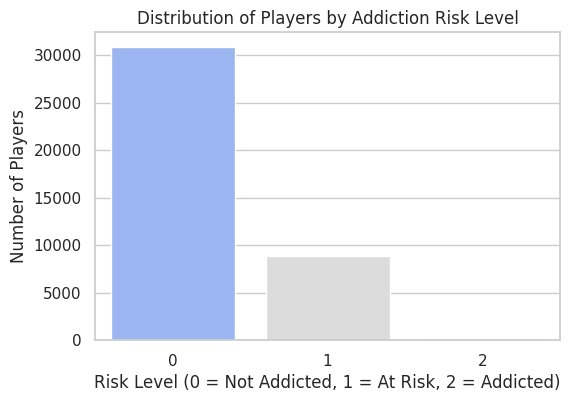


Class Distribution (%):
AddictionRiskLevel
0    77.17
1    22.11
2     0.72
Name: proportion, dtype: float64


In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x='AddictionRiskLevel', data=df_clean, palette='coolwarm')
plt.title("Distribution of Players by Addiction Risk Level")
plt.xlabel("Risk Level (0 = Not Addicted, 1 = At Risk, 2 = Addicted)")
plt.ylabel("Number of Players")
plt.show()

# Show percentage composition for each class
risk_counts = df_clean['AddictionRiskLevel'].value_counts(normalize=True) * 100
print("\nClass Distribution (%):")
print(risk_counts.round(2))


**# 2. AGE DISTRIBUTION BY RISK LEVEL**

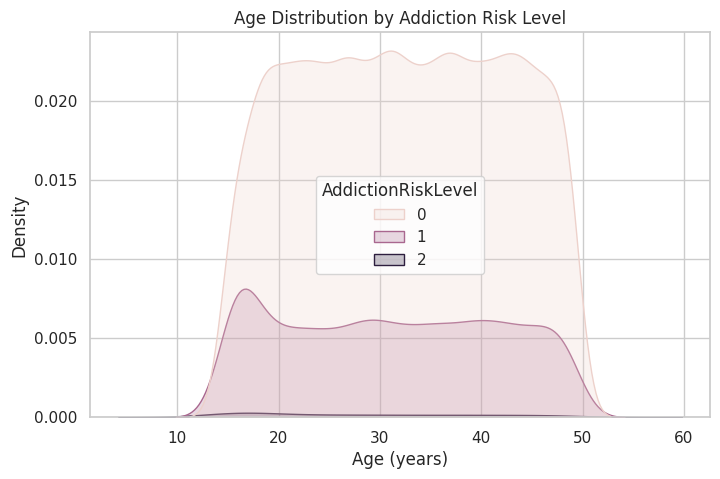

In [4]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_clean, x='Age', hue='AddictionRiskLevel', fill=True)
plt.title("Age Distribution by Addiction Risk Level")
plt.xlabel("Age (years)")
plt.ylabel("Density")
plt.show()


**# 3. PLAYTIME VS RISK LEVEL**

/tmp/ipython-input-2903430192.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='PlayTimeHours', palette='coolwarm')


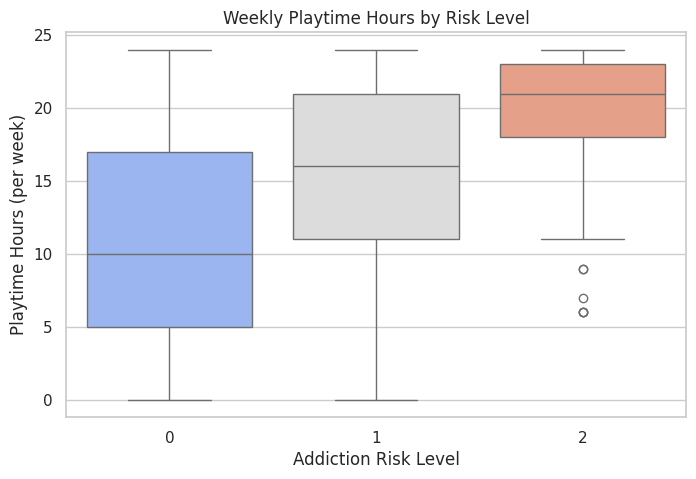

In [5]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='PlayTimeHours', palette='coolwarm')
plt.title("Weekly Playtime Hours by Risk Level")
plt.xlabel("Addiction Risk Level")
plt.ylabel("Playtime Hours (per week)")
plt.show()

**# 4. SESSION BEHAVIOR**

/tmp/ipython-input-2694997096.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='SessionsPerWeek', ax=axes[0], palette='mako')
/tmp/ipython-input-2694997096.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='AvgSessionDurationMinutes', ax=axes[1], palette='mako')


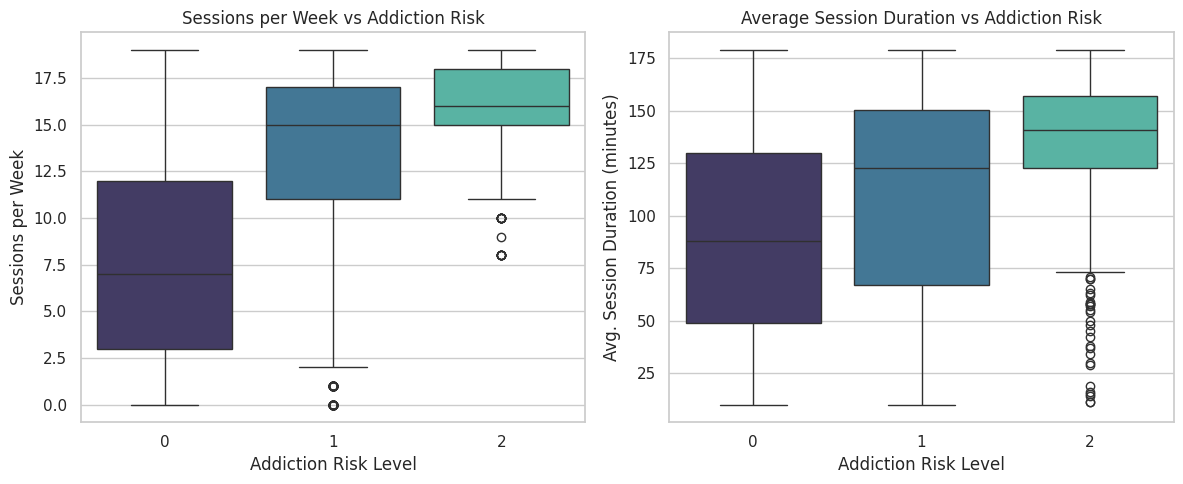

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='SessionsPerWeek', ax=axes[0], palette='mako')
axes[0].set_title("Sessions per Week vs Addiction Risk")
axes[0].set_xlabel("Addiction Risk Level")
axes[0].set_ylabel("Sessions per Week")

sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='AvgSessionDurationMinutes', ax=axes[1], palette='mako')
axes[1].set_title("Average Session Duration vs Addiction Risk")
axes[1].set_xlabel("Addiction Risk Level")
axes[1].set_ylabel("Avg. Session Duration (minutes)")

plt.tight_layout()
plt.show()


**# 5. IN-GAME PURCHASES AND SPENDING BEHAVIOR**

/tmp/ipython-input-673604653.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-673604653.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


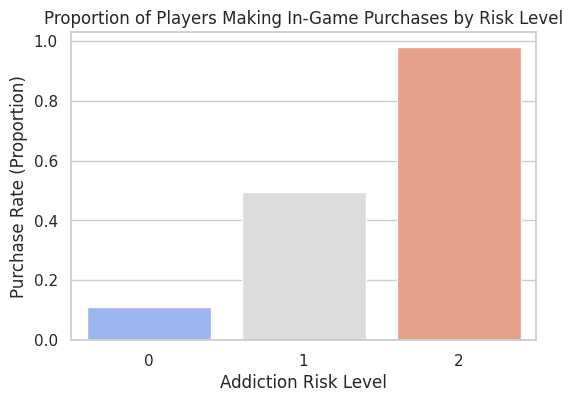

/tmp/ipython-input-673604653.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='SpendingRate', palette='coolwarm')


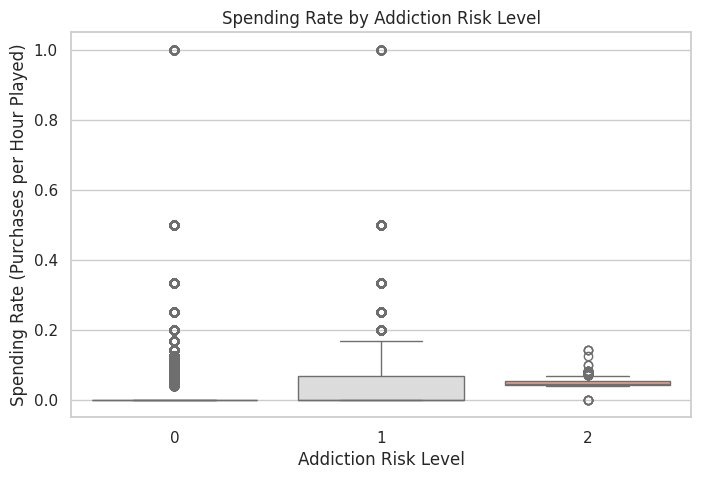

In [7]:
plt.figure(figsize=(6,4))
sns.barplot(
    x='AddictionRiskLevel',
    y='InGamePurchases',
    data=df_clean,
    estimator=lambda x: sum(x)/len(x),
    ci=None,
    palette='coolwarm'
)
plt.title("Proportion of Players Making In-Game Purchases by Risk Level")
plt.xlabel("Addiction Risk Level")
plt.ylabel("Purchase Rate (Proportion)")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='SpendingRate', palette='coolwarm')
plt.title("Spending Rate by Addiction Risk Level")
plt.xlabel("Addiction Risk Level")
plt.ylabel("Spending Rate (Purchases per Hour Played)")
plt.show()

**# 6. ACHIEVEMENTS AND PLAYER LEVEL**

/tmp/ipython-input-1105246386.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='PlayerLevel', ax=axes[0], palette='crest')
/tmp/ipython-input-1105246386.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='AchievementsUnlocked', ax=axes[1], palette='crest')


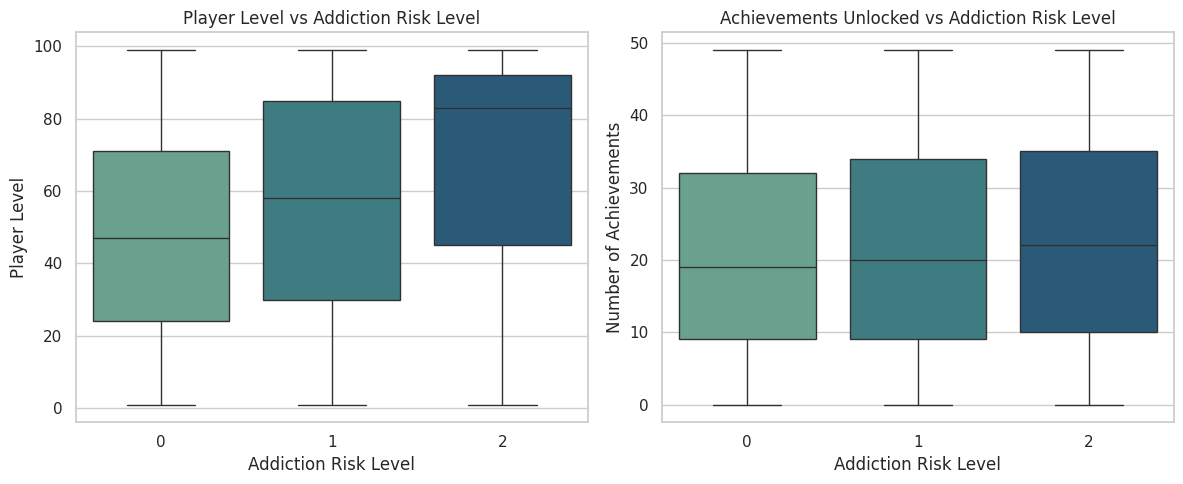

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='PlayerLevel', ax=axes[0], palette='crest')
axes[0].set_title("Player Level vs Addiction Risk Level")
axes[0].set_xlabel("Addiction Risk Level")
axes[0].set_ylabel("Player Level")

sns.boxplot(data=df_clean, x='AddictionRiskLevel', y='AchievementsUnlocked', ax=axes[1], palette='crest')
axes[1].set_title("Achievements Unlocked vs Addiction Risk Level")
axes[1].set_xlabel("Addiction Risk Level")
axes[1].set_ylabel("Number of Achievements")

plt.tight_layout()
plt.show()


**# 7. GAME GENRE PREFERENCES**

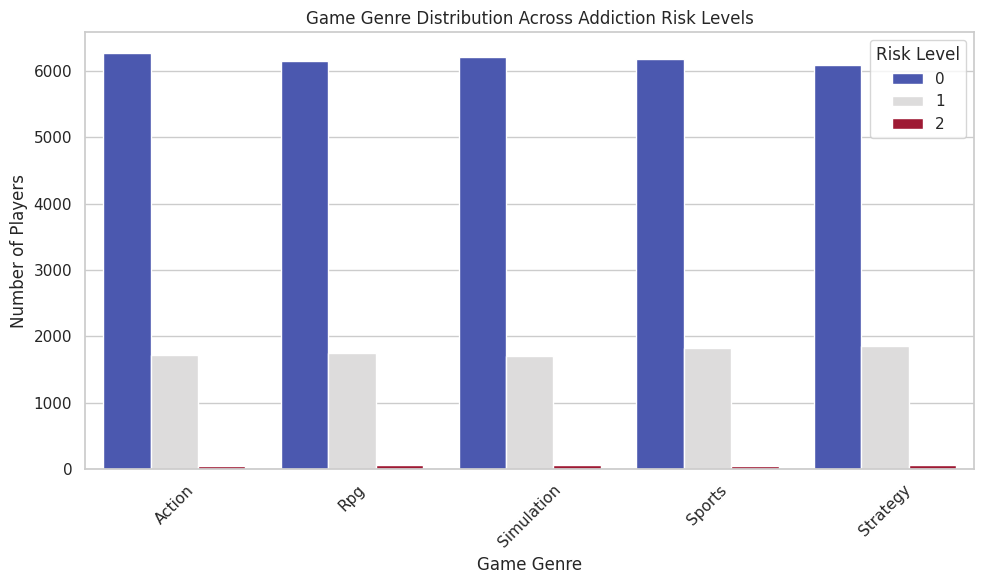

In [9]:
plt.figure(figsize=(10,6))
genre_risk = df_clean.groupby(['GameGenre', 'AddictionRiskLevel']).size().reset_index(name='Count')
sns.barplot(data=genre_risk, x='GameGenre', y='Count', hue='AddictionRiskLevel', palette='coolwarm')
plt.title("Game Genre Distribution Across Addiction Risk Levels")
plt.xlabel("Game Genre")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)
plt.legend(title="Risk Level", loc='upper right')
plt.tight_layout()
plt.show()


**# 8. CORRELATION ANALYSIS**

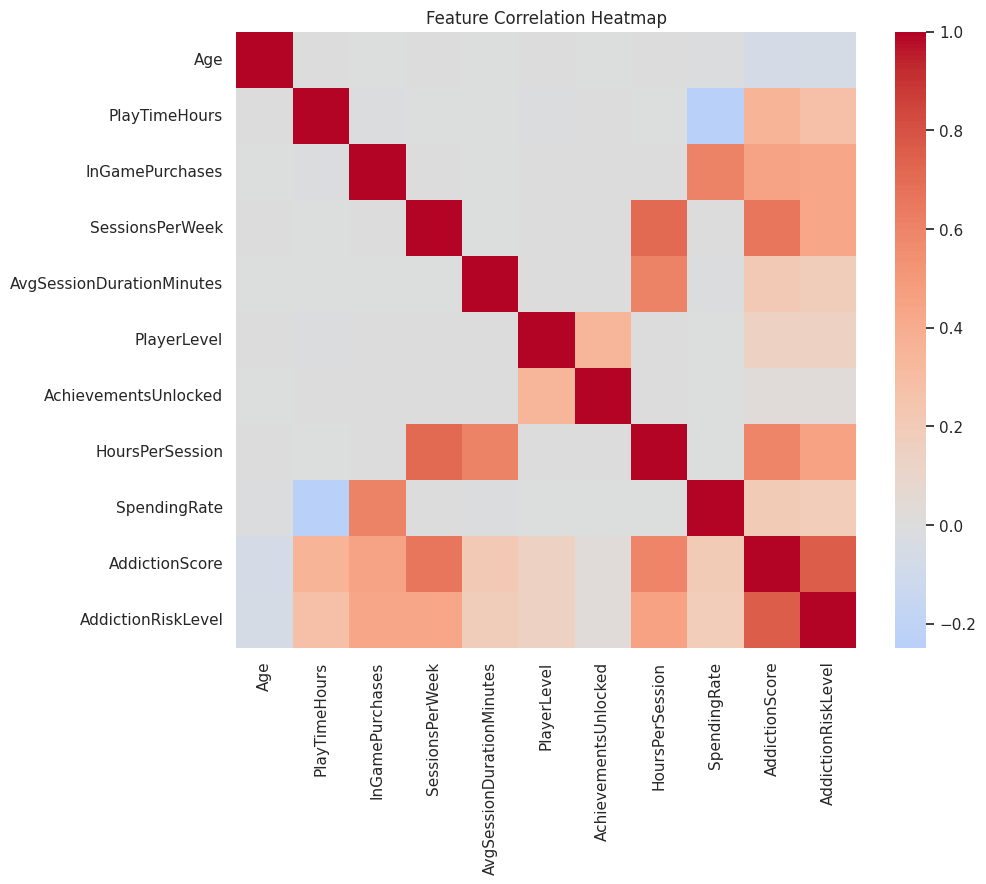

In [10]:
# Compute correlations only for numeric columns
corr = df_clean.select_dtypes(include=np.number).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


**# 9. INSIGHTS SUMMARY**

In [12]:
print("\n--- KEY INSIGHTS ---")
print("1. The majority of players fall under the 'Not Addicted' or 'At Risk' categories.")
print("2. Addicted players generally have higher playtime, more sessions per week, and longer sessions.")
print("3. The 'At Risk' group shares patterns with addicted players, but with slightly lower intensity.")
print("4. Younger players (<18) appear overrepresented in the 'At Risk' and 'Addicted' categories.")
print("5. In-game purchases and higher player levels correlate with increased addiction likelihood.")
print("6. Certain genres (e.g., MMORPG, Battle Royale) show higher concentration of addicted players.")


--- KEY INSIGHTS ---
1. The majority of players fall under the 'Not Addicted' or 'At Risk' categories.
2. Addicted players generally have higher playtime, more sessions per week, and longer sessions.
3. The 'At Risk' group shares patterns with addicted players, but with slightly lower intensity.
4. Younger players (<18) appear overrepresented in the 'At Risk' and 'Addicted' categories.
5. In-game purchases and higher player levels correlate with increased addiction likelihood.
6. Certain genres (e.g., MMORPG, Battle Royale) show higher concentration of addicted players.


**l) EDA SUMMARY**

In [15]:
# ===============================================================
# EDA SUMMARY STATISTICS
# ===============================================================

print("EDA Summary:")

# Overall descriptive metrics
print(f"- Average playtime: {df_clean['PlayTimeHours'].mean():.1f} hours/week")
print(f"- Average sessions per week: {df_clean['SessionsPerWeek'].mean():.1f}")
print(f"- Average session duration: {df_clean['AvgSessionDurationMinutes'].mean():.1f} minutes")
print(f"- % of players making in-game purchases: {df_clean['InGamePurchases'].mean() * 100:.1f}%")

# Distribution of risk categories
risk_counts = df_clean['AddictionRiskLevel'].value_counts(normalize=True) * 100
print("\nAddiction Risk Distribution:")
for level, pct in risk_counts.items():
    label = {0: 'Not Addicted', 1: 'At Risk', 2: 'Addicted'}[level]
    print(f"  - {label}: {pct:.1f}%")

# Correlation of numeric features with AddictionScore
corr_target = (
    df_clean.select_dtypes(include=np.number)
    .corr()['AddictionScore']
    .sort_values(ascending=False)
)

print("\nTop 5 Features Most Correlated with Addiction Score:")
for feature, corr_val in corr_target.head(6).items():
    if feature != 'AddictionScore':  # skip self-correlation
        print(f"  - {feature}: {corr_val:.3f}")



EDA Summary:
- Average playtime: 12.0 hours/week
- Average sessions per week: 9.5
- Average session duration: 94.8 minutes
- % of players making in-game purchases: 20.1%

Addiction Risk Distribution:
  - Not Addicted: 77.2%
  - At Risk: 22.1%
  - Addicted: 0.7%

Top 5 Features Most Correlated with Addiction Score:
  - AddictionRiskLevel: 0.761
  - SessionsPerWeek: 0.656
  - HoursPerSession: 0.597
  - InGamePurchases: 0.453
  - PlayTimeHours: 0.352


#### 3) MODEL DEVELOPMENT, TESTING AND EVALUATION

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:27:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Logistic Regression Performance:

              precision    recall  f1-score   support

           0      0.939     0.954     0.946      9269
           1      0.814     0.776     0.795      2655
           2      0.705     0.494     0.581        87

    accuracy                          0.911     12011
   macro avg      0.819     0.741     0.774     12011
weighted avg      0.909     0.911     0.910     12011



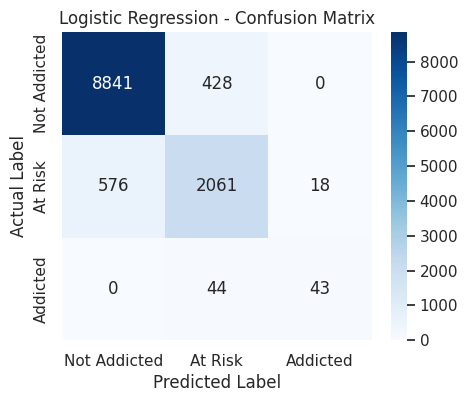

Random Forest Performance:

              precision    recall  f1-score   support

           0      0.997     1.000     0.999      9269
           1      0.992     0.991     0.991      2655
           2      1.000     0.759     0.863        87

    accuracy                          0.996     12011
   macro avg      0.996     0.916     0.951     12011
weighted avg      0.996     0.996     0.996     12011



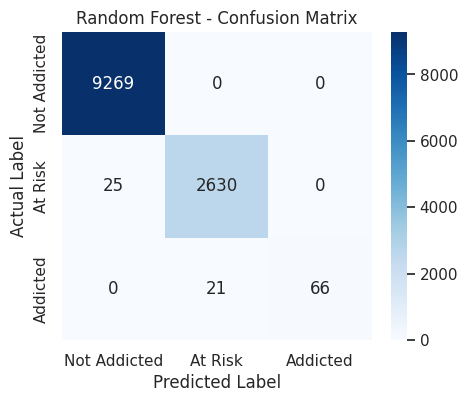

XGBoost Performance:

              precision    recall  f1-score   support

           0      1.000     1.000     1.000      9269
           1      0.998     0.999     0.998      2655
           2      0.988     0.943     0.965        87

    accuracy                          0.999     12011
   macro avg      0.995     0.980     0.988     12011
weighted avg      0.999     0.999     0.999     12011



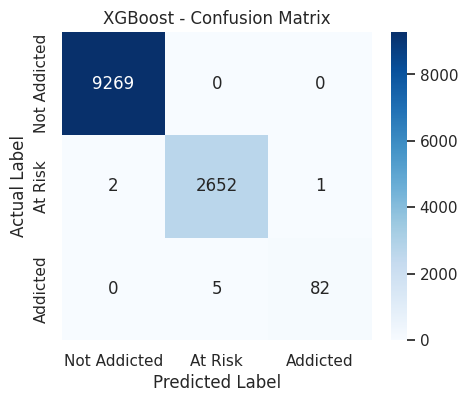



MODEL COMPARISON TABLE (MULTI-CLASS)


,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
XGBoost,0.999334,0.995285,0.980466,0.987697
Random Forest,0.996170,0.996463,0.916401,0.950910
Logistic Regression,0.911248,0.819137,0.741450,0.773959


In [16]:
# ===============================================================
# MODEL DEVELOPMENT AND EVALUATION (MULTI-CLASS)
# ===============================================================

# Remove any leftover 'AddictionScore' column to prevent data leakage
df_clean = df_clean.drop(columns=['AddictionScore'], errors='ignore')

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Set Seaborn plotting style
sns.set_theme(style="whitegrid")

# Drop columns that are non-predictive or redundant
df_clean = df_clean.drop(columns=['Location', 'EngagementLevel'], errors='ignore')

# Encode categorical variables
label_cols = ['Gender', 'Region', 'GameGenre', 'GameDifficulty']
encoder = LabelEncoder()
for col in label_cols:
    df_clean[col] = encoder.fit_transform(df_clean[col])

# ---------------------------------------------------------------
# Define Features and Multi-Class Target
# ---------------------------------------------------------------
X = df_clean.drop(columns=['AddictionRiskLevel'])
y = df_clean['AddictionRiskLevel']

# Split data into train/test sets (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize numerical features for models sensitive to scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------------------------------------------
# Initialize Models
# ---------------------------------------------------------------
# Logistic Regression (set to multinomial mode for 3 classes)
log_model = LogisticRegression(
    multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42
)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric='mlogloss', random_state=42, num_class=3
)

# ---------------------------------------------------------------
# Train Models
# ---------------------------------------------------------------
log_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# ---------------------------------------------------------------
# Generate Predictions
# ---------------------------------------------------------------
y_pred_log = log_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Store predictions
models = {
    "Logistic Regression": y_pred_log,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

# ---------------------------------------------------------------
# Evaluate Models (Multi-class)
# ---------------------------------------------------------------
for name, preds in models.items():
    print("="*60)
    print(f"{name} Performance:\n")
    print(classification_report(y_test, preds, digits=3))

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Addicted','At Risk','Addicted'],
                yticklabels=['Not Addicted','At Risk','Addicted'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

# ---------------------------------------------------------------
# Model Comparison Summary Table
# ---------------------------------------------------------------

def model_metrics_multiclass(y_true, y_pred):
    """Compute macro-averaged performance metrics for multi-class classification."""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (Macro)": precision_score(y_true, y_pred, average='macro'),
        "Recall (Macro)": recall_score(y_true, y_pred, average='macro'),
        "F1-Score (Macro)": f1_score(y_true, y_pred, average='macro')
    }

results = {name: model_metrics_multiclass(y_test, preds) for name, preds in models.items()}
results_df = pd.DataFrame(results).T.sort_values(by="F1-Score (Macro)", ascending=False)

print("\n\nMODEL COMPARISON TABLE (MULTI-CLASS)")
display(results_df)


***ROC-AUC VISUALIZATION**

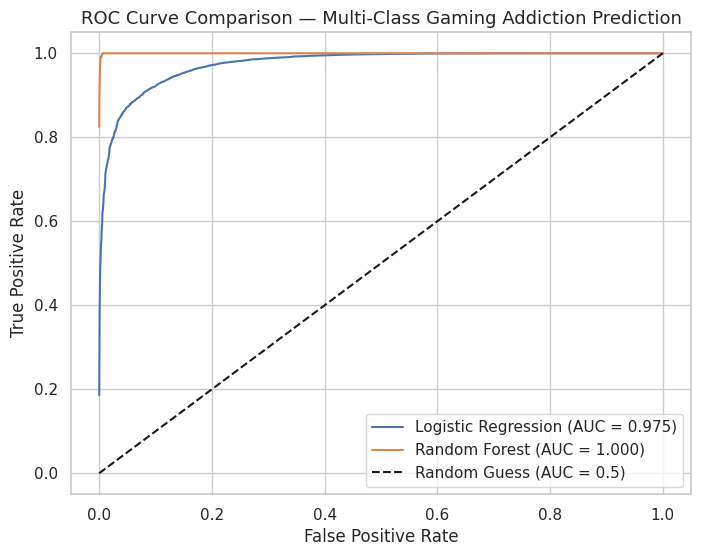

In [18]:

# ===============================================================
# MULTI-CLASS ROC–AUC COMPARISON (One-vs-Rest)
# ===============================================================

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from itertools import cycle

# Binarize the multi-class target for one-vs-rest ROC computation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8,6))

# ---------------------------------------------------------------
# Logistic Regression ROC (Multiclass)
# ---------------------------------------------------------------
y_score_log = log_model.predict_proba(X_test_scaled)
fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()

for i in range(n_classes):
    fpr_log[i], tpr_log[i], _ = roc_curve(y_test_bin[:, i], y_score_log[:, i])
    roc_auc_log[i] = auc(fpr_log[i], tpr_log[i])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr_log[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_log[i], tpr_log[i])
mean_tpr /= n_classes

roc_auc_log_macro = auc(all_fpr, mean_tpr)
plt.plot(all_fpr, mean_tpr, label=f"Logistic Regression (AUC = {roc_auc_log_macro:.3f})")

# ---------------------------------------------------------------
# Random Forest ROC (Multiclass)
# ---------------------------------------------------------------
y_score_rf = rf_model.predict_proba(X_test)
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Compute macro-average ROC
all_fpr_rf = np.unique(np.concatenate([fpr_rf[i] for i in range(n_classes)]))
mean_tpr_rf = np.zeros_like(all_fpr_rf)
for i in range(n_classes):
    mean_tpr_rf += np.interp(all_fpr_rf, fpr_rf[i], tpr_rf[i])
mean_tpr_rf /= n_classes

roc_auc_rf_macro = auc(all_fpr_rf, mean_tpr_rf)
plt.plot(all_fpr_rf, mean_tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf_macro:.3f})")

# ---------------------------------------------------------------
# Plot settings
# ---------------------------------------------------------------
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
plt.title("ROC Curve Comparison — Multi-Class Gaming Addiction Prediction", fontsize=13)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



***FEATURE IMPORTANCE ANALYSIS**


1) LOGISTIC REGRESSION

/tmp/ipython-input-1256184969.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeff_df.head(15), palette='viridis')


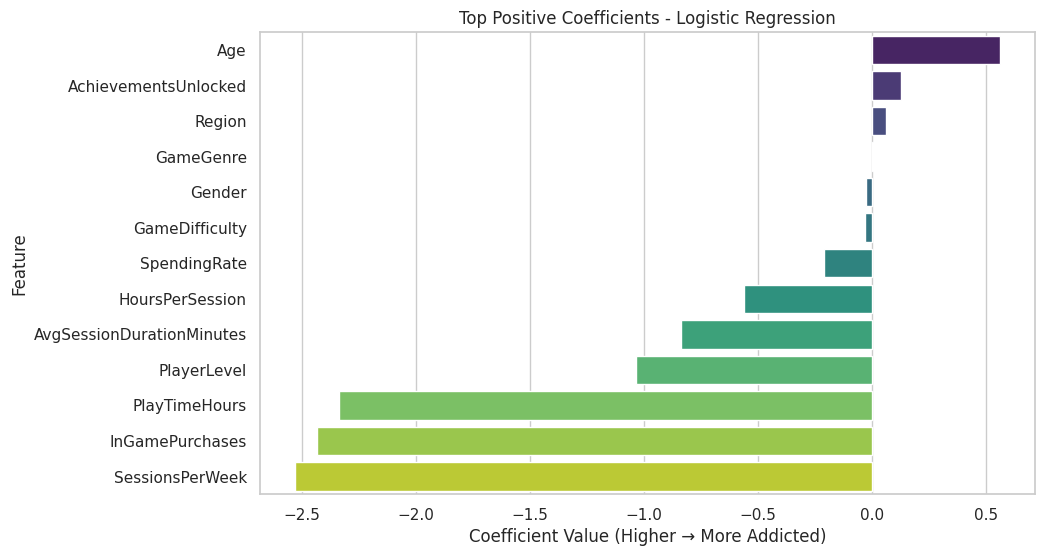

In [20]:
# Logistic Regression Coefficients
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]  # For first class (multinomial)
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coeff_df.head(15), palette='viridis')
plt.title("Top Positive Coefficients - Logistic Regression")
plt.xlabel("Coefficient Value (Higher → More Addicted)")
plt.ylabel("Feature")
plt.show()


2) RANDOM FOREST

/tmp/ipython-input-746217084.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='crest')


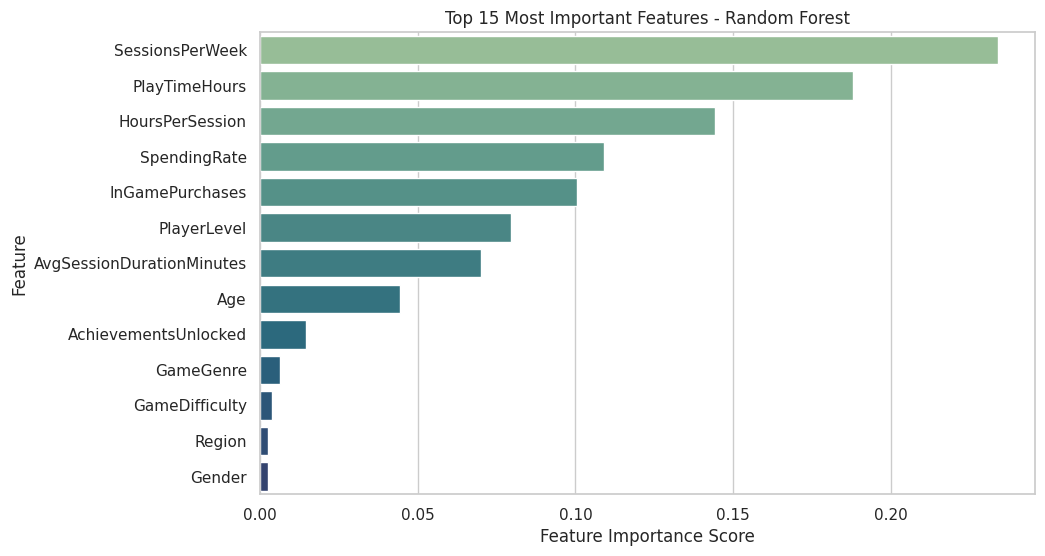

In [21]:
# Random Forest Feature Importance
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='crest')
plt.title("Top 15 Most Important Features - Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()
